# Logistic Regression Analysis Experiment




In [1]:
!pip install ucimlrepo

In [2]:
from tqdm import tqdm
import numpy as np
import sklearn as sk
import pandas as pd
import sklearn.model_selection
import matplotlib.pyplot as plt
import random
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# utils
def normalize_features(df, method='z-score'):
    # Extract the feature columns (excluding 'MEDV')
    feature_cols = [col for col in df.columns if col != 'MEDV']

    if method == 'z-score':
        # Z-score normalization
        means = df[feature_cols].mean()
        std_devs = df[feature_cols].std()

        # Apply z-score normalization to the feature columns
        normalized_df = df.copy()
        normalized_df[feature_cols] = (df[feature_cols] - means) / std_devs
    elif method == 'min-max':
        # Min-max scaling
        min_val = df[feature_cols].min()
        max_val = df[feature_cols].max()

        # Apply Min-max scaling normalization to the feature columns
        normalized_df = df.copy()
        normalized_df[feature_cols] = (df[feature_cols] - min_val) / (max_val - min_val)
    else:
        raise ValueError("Invalid normalization method.")

    return normalized_df

def draw_loss(L_vals):
    plt.plot(list(range(len(L_vals))), L_vals, '-o', color='blue')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Iterations VS Loss')
    plt.show()

def softmax(u):
    # return np.exp(u) / np.sum(np.exp(u))
    # use log_softmax instead to prevent overflow
    return np.exp(u - np.max(u) - np.log(np.sum(np.exp(u - np.max(u)))))

def cross_entropy(p, q, eps=1e-10):
    q = np.clip(q, eps, 1 - eps)
    return -p @ np.log(q)


def Xhat(X):
    if len(X.shape) == 1:
        return np.insert(X, 0, 1)
    return np.column_stack((np.ones((X.shape[0], 1)),X))

def grad_L_m(X, y, beta):
    if len(X.shape) == 1:
        return np.outer(Xhat(X), (softmax(Xhat(X) @ beta) - y))
    return (np.transpose(Xhat(X)) @ (softmax(Xhat(X) @ beta) - y)) / X.shape[0]

def eval_L_m(X, y, beta):
    return np.average([cross_entropy(y[index], softmax(xi @ beta)) for index, xi in enumerate(Xhat(X))])

def train_model_using_grad_descent_multi(X, y, alpha, max_iter):
    beta = np.zeros((X.shape[1] + 1, y.shape[1])).astype("float64")
    L_vals = []
    for _ in tqdm(range(max_iter)):
        beta = beta - alpha * grad_L_m(X, y, beta)
        L_vals.append(eval_L_m(X, y, beta))
    return beta, L_vals

def MSE(Yhat, Y):
    n = Yhat.shape[0]
    res = (Yhat - Y) ** 2

    return sum(res)/n


def L2gradient(X, Y, Yhat):
     # Also applicable for Log gradient
     return (X.T @ (Yhat - Y)) / X.shape[0]

def onehot(arr):
    unique_classes, inverse = np.unique(arr, return_inverse=True)
    arr= np.zeros((len(arr), len(unique_classes)))
    arr[np.arange(len(arr)), inverse] = 1

    return arr

def zerohot(df, axis = 0):
    # input: array or dataframe that is one-hot encoded or simply categorical, the axis along which we decode (default = 0)
    # returns: the argmax value of the one-hot encoded columns/axes
    unhot = np.argmax(df, axis)
    return unhot

def cMatrix_log(Yhat, Y, axis = (0,1), onehot = False):
    # logistic regression confusion matrix
    # Inputs Yhat: predicted values, Y: expected values. Yhat and Y can be either lists, np.arrays.
    # Axis tuple to precise along which axis of the matrix we decode for Yhat, Y respectively
    # returns df of confusion matrix
    if not onehot:
        d = {'Predicted Values': Yhat, 'Actual Values': Y}
        df = pd.DataFrame(data = d)

        cMat = pd.crosstab(df["Predicted Values"], df['Actual Values'])
        fig, ax = plt.subplots(1, 1, figsize = (10,5))
        ax.set_title('Confusion Matrix for Logistic Regression')
        sns.heatmap(cMat, annot = True)

    else:
        d = {'Predicted Values': zerohot(Yhat, axis[0]), 'Actual Values': zerohot(Y, axis[1])}
        df = pd.DataFrame(data = d)

        cMat = pd.crosstab(df["Predicted Values"], df['Actual Values'])
        fig, ax = plt.subplots(1, 1, figsize = (10,5))
        ax.set_title('Confusion Matrix for Logistic Regression')
        sns.heatmap(cMat, annot = True)

    # The code that follows will only run after all plots have been drawn
    plt.show()
    return cMat

def ComputeMetrics(cMat):
    for idx in range(cMat.shape[0]):
        TP = np.sum(cMat.iloc[idx,idx])
        FP = np.sum(cMat.iloc[idx,:]) - TP
        FN = np.sum(cMat.iloc[:,idx]) - TP
        TN = np.sum(cMat.sum()) - TP - FP - FN

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        F1 = 2 * precision * recall / (precision + recall)

        print("Category: %d, Metrics for accuracy: %f, precision: %f, recall: %f, F1: %f" % (idx, accuracy, precision, recall, F1))

# Replace ComputeMetrics
def printMetrics(cMat):
    accuracy, precision, recall, F1 = metrics_cal(cMat)
    print("Metrics for avg_accuracy: %f, avg_precision: %f, avg_recall: %f, avg_F1: %f" % (
        accuracy, precision, recall, F1))

def cMat_builder(Yhat, Y):
    df = pd.DataFrame(data={'Predicted Values': Yhat, 'Actual Values': Y})
    return pd.crosstab(df["Predicted Values"], df['Actual Values'])

def metrics_cal(cMat):
    # Initialize the avg of metrics
    accuracy = precision = recall = F1 = 0
    for idx in range(cMat.shape[0]):
        TP = np.sum(cMat.iloc[idx, idx])
        FP = np.sum(cMat.iloc[idx, :]) - TP
        FN = np.sum(cMat.iloc[:, idx]) - TP
        TN = np.sum(cMat.sum()) - TP - FP - FN

        accuracy += (TP + TN) / (TP + TN + FP + FN)
        precision += TP / (TP + FP)
        recall += TP / (TP + FN)
        if precision + recall != 0:
            F1_temp = 2 * precision * recall / (precision + recall)
        else:
            F1_temp = 0.0

        F1 += F1_temp
    return accuracy / cMat.shape[0], precision / cMat.shape[0], recall / cMat.shape[0], F1 / cMat.shape[0]


def metricsWrapper(y_train_hat, y_train, y_test_hat, y_test):
    print("Overall Accuracy for training set: ", str(np.average(y_train_hat == y_train)))
    print("Performance metrics for training set: ")
    printMetrics(cMatrix_log(y_train_hat, y_train))

    print("==========================")
    print("Overall Accuracy for test set: ", str(np.average(y_test_hat == y_test)))
    print("Performance metrics for test set:")
    printMetrics(cMatrix_log(y_test_hat, y_test))

# for CV
def split_indices(indices, N=5):
    np.random.shuffle(indices)
    return np.array_split(indices, N)


def plot_metrics_with_diff_training_size(metrics_df_ts, metricsList: list):
    plt.figure(figsize=(10, 6))
    for metric in metricsList:
        plt.plot(metrics_df_ts['training_size'], metrics_df_ts[metric], label=metric, marker='o')

    plt.xlabel('Training Size')
    plt.ylabel('Metric Value')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_metrics_with_diff_learning_rates(metrics_df_lr, metricsList: list):
    plt.figure(figsize=(10, 6))
    for metric in metricsList:
        plt.plot(metrics_df_lr['learning_rates'], metrics_df_lr[metric], label=metric, marker='o')

    plt.xlabel('learning_rates')
    plt.ylabel('Metric Value')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

## Task 1: Acquire, preprocess, and analyze the data

### I. Data cleaning and pre-processing

In [4]:
# Fetch dataset
wine = fetch_ucirepo(id=109)

# Create DataFrames for features (X) and classification class (y)
X = pd.DataFrame(data=wine.data.features)
y = pd.DataFrame(data=wine.data.targets)
wine_df = pd.concat([X, y], axis=1)

# Check missing value (NaN)
missing_values = wine_df.isnull().any().any()
# Check non-numeric values
malformed_values = wine_df.select_dtypes(exclude=['number']).any().any()
missing_values, malformed_values

(False, False)

### II. Exploratory Data Analysis

In [5]:
wine_df.head()

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


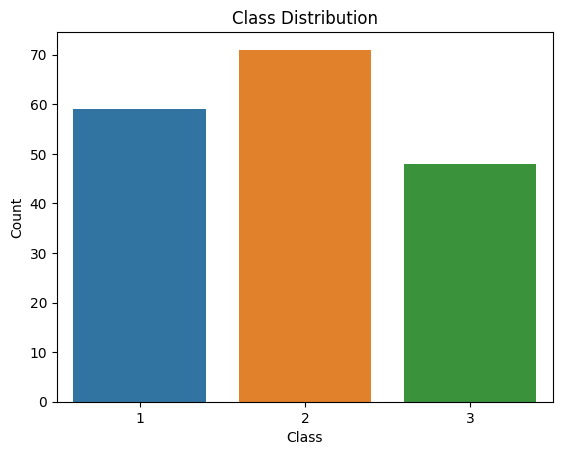

In [6]:
# Distributions of the different classes
ax = sns.countplot(data=wine_df, x='class')
ax.set(xlabel='Class', ylabel='Count', title='Class Distribution')
plt.show()

Distributions between classes are roughly even. There are slightly more class 2 wines and less class three wines.

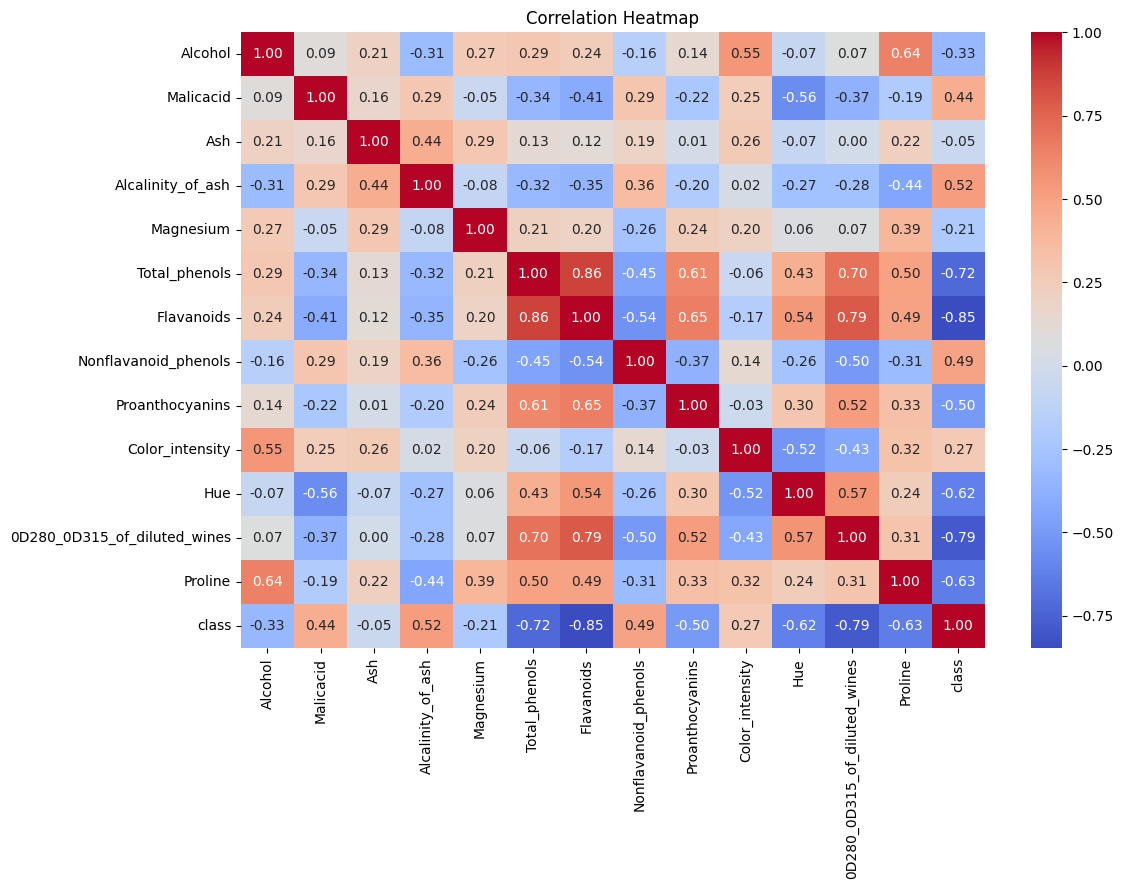

In [7]:
# correlation between features
correlation_matrix = wine_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Top 3 highest correlation with class: Flavanoids, diluted_wines, total_phenols which may indicates these three features are most important.

## Task 2: Implement the models

### 2.2 Logistic Regression with gradient descent

In [8]:
# Multiclass Gradient descent
class LogisticRegression:

    def __init__(self, alpha=0.01, max_iter=500):
        self.beta = None
        self.L_vals = None
        self.alpha = alpha
        self.max_iter = max_iter

    def fit(self, X_train, y_train):
        # one-hot-encoding y_train
        unique_classes, inverse = np.unique(y_train, return_inverse=True)
        y_train_hot = np.zeros((len(y_train), len(unique_classes)))
        y_train_hot[np.arange(len(y_train)), inverse] = 1

        self.beta, self.L_vals = train_model_using_grad_descent_multi(X_train, y_train_hot, self.alpha, self.max_iter)
        return self

    def predict(self, X_test):
        # first class in y_pred is class 2 in Y
        y_pred = [np.argmax(yi) + 1 for yi in (Xhat(X_test) @ self.beta)]
        return y_pred

### 2.3 Logistic Regression with mini-batch stochastic gradient descent

In [9]:
# Multiclass Gradient Descent with SGD
class logReg_SGD:
    def __init__(self, alpha = 0.01, max_iter = 500, eps = 0.0001, size = None):
        # Size parameter is asking for the size of the weight matrix
        # Which is usually D x C (features x categories)
        # The Y expectation matrix should be one-hot encoded before being inputted
        self.w = np.random.randn(size[0], size[1])
        self.max_iter = max_iter
        self.alpha = alpha
        self.cost = []
        self.eps = eps
        self.grad = 1

    # Feed the X data in a forward loop
    def forwardpass(self, X):
        a = np.dot(X, self.w)

        return a

    def SGD(self, X, Y, epochs, mini_batch_size, test_data=None):
        m,n = X.shape
        if test_data:
            Xtest, Ytest = test_data
            Xtest = Xtest.values

        for i in tqdm(range(1,epochs+1)):
            if np.linalg.norm(self.grad) < self.eps: break;
            temp = list(zip(X.values,Y))
            random.shuffle(temp)
            Xshuffled, Yshuffled = zip(*temp)
            Xshuffled, Yshuffled = np.array(Xshuffled), np.array(Yshuffled)

            for k in range(0, m, mini_batch_size):
                Xmini, Ymini = Xshuffled[k:k+mini_batch_size], Yshuffled[k:k+mini_batch_size]
                self.update_mini_batch(Xmini, Ymini, self.alpha)
            # if test_data:
            #         print("Epoch {0}: {1} / {2}".format(
            #             i, self.eval(test_data = test_data), len(Xtest)))
            # else:
            #         print("Epoch {0} complete".format(i))

    def update_mini_batch(self, X, Y, alpha):
        yhat = self.forwardpass(X)
        grad = L2gradient(X, Y, yhat)
        self.w = self.w - alpha * grad
        self.grad = np.mean(grad)

    def eval(self, test_data = None):
        Xtest, Ytest = test_data
        prediction = self.forwardpass(Xtest)
        predictions = np.argmax(prediction, axis = 1)
        expected = np.argmax(Ytest, axis = 1)
        return sum(predictions == expected)

    def predict(self, Xtest):
        prediction = self.forwardpass(Xtest)
        out = softmax(prediction)

        return np.argmax(prediction, axis = 1)

## Task 3: Run experiemnts

### 3.1 Accuracy, precision, recall, and F1-score for each model (82split, metrics for training and test set)

#### 3.1.1 Gradient descent

100%|██████████| 300/300 [00:05<00:00, 51.80it/s]


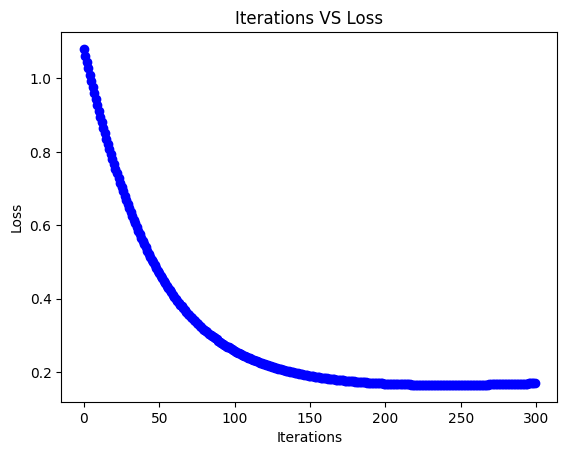

In [10]:
X = normalize_features(X)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=311)

model = LogisticRegression(alpha=0.01, max_iter=300)
logReg = model.fit(X_train, y_train)

# Iteration VS Loss plot
draw_loss(logReg.L_vals)

# performance metrics
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

Overall Accuracy for training set:  0.9225352112676056
Performance metrics for training set: 


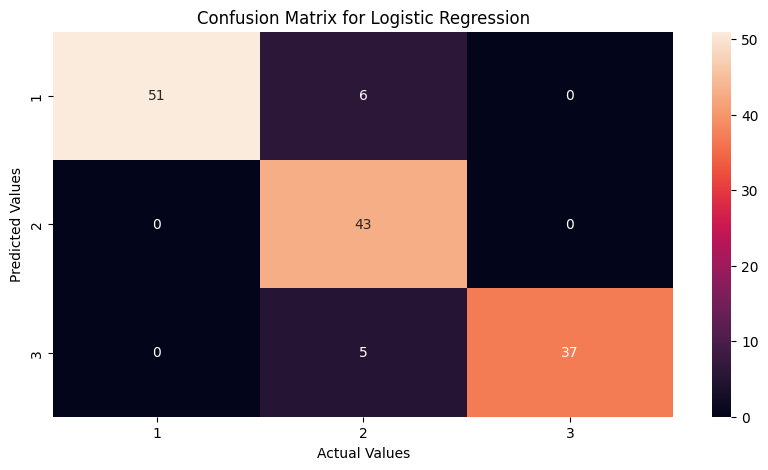

Metrics for avg_accuracy: 0.948357, avg_precision: 0.925230, avg_recall: 0.932099, avg_F1: 1.858201
Overall Accuracy for test set:  0.9444444444444444
Performance metrics for test set:


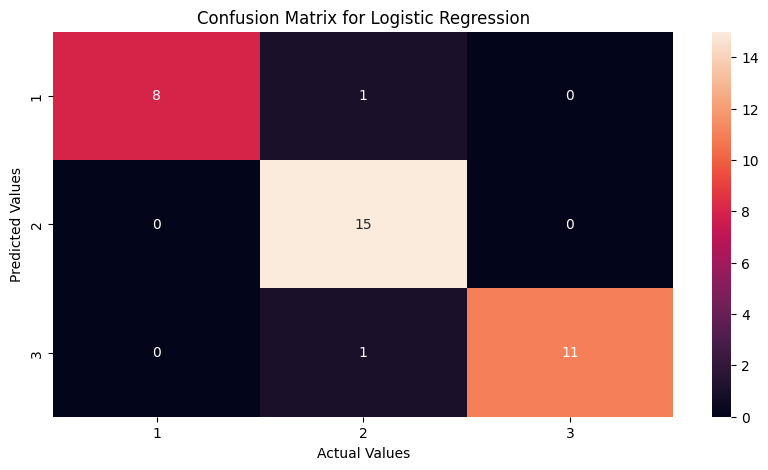

Metrics for avg_accuracy: 0.962963, avg_precision: 0.935185, avg_recall: 0.960784, avg_F1: 1.890076


In [11]:
metricsWrapper(y_train_hat, y_train['class'].values, y_test_hat, y_test['class'].values)

#### 3.1.2 Mini-batch stochastic gradient descent

100%|██████████| 300/300 [00:01<00:00, 233.77it/s]


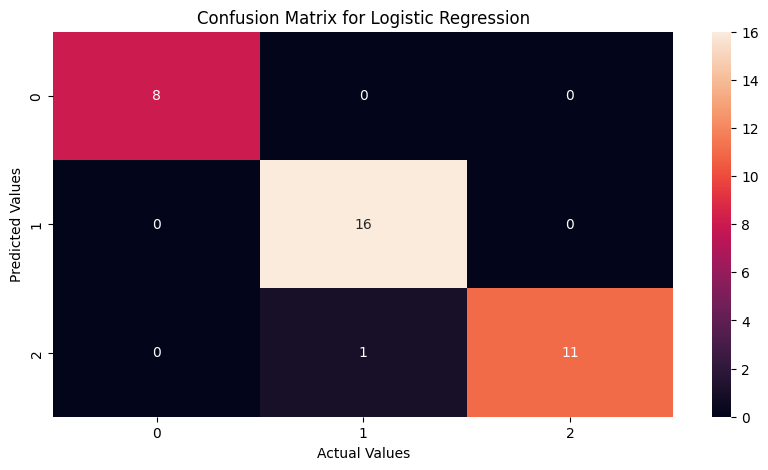

Metrics for avg_accuracy: 0.981481, avg_precision: 0.972222, avg_recall: 0.980392, avg_F1: 1.966340


In [12]:
# Testing out SGD logistic regression
ytrain, ytest = y_train, y_test
ytrain, ytest = onehot(ytrain), onehot(ytest)
model_SGD = logReg_SGD(alpha = 0.01, max_iter = 500, size = [X_train.shape[1], ytrain.shape[1]])
model_SGD.SGD(X_train, ytrain, epochs = 300, mini_batch_size = 4, test_data = (X_test, ytest))

ypred = onehot(np.array(model_SGD.predict(X_test)))

cMat = cMatrix_log(ypred, ytest,  axis = (1,1), onehot = True)
printMetrics(cMat)

### 3.2 5-fold CV for each model (metrics for training and test set)

#### 3.2.1 Gradient descent

In [13]:
# train_accuracy, train_precision, train_recall, train_F1, test_accuracy, test_precision, test_recall, test_F1
metrics = [0 for x in range(8)]
folds_indices = split_indices(wine_df.index.tolist())
for idx, indices in enumerate(split_indices(wine_df.index.tolist())):
    X_train = X.iloc[np.concatenate(folds_indices[:idx] + folds_indices[idx + 1:])]
    X_test = X.iloc[indices.tolist()]
    y_train = y.iloc[np.concatenate(folds_indices[:idx] + folds_indices[idx + 1:])]
    y_test = y.iloc[indices.tolist()]

    model = LogisticRegression(alpha=0.01, max_iter=70)
    logReg = model.fit(X_train, y_train)
    # draw_loss(logReg.L_vals)
    y_train_hat = model.predict(X_train)
    y_test_hat = model.predict(X_test)
    train_accuracy, train_precision, train_recall, train_F1 = metrics_cal(cMat_builder(y_train_hat, y_train['class'].values))
    test_accuracy, test_precision, test_recall, test_F1 = metrics_cal(cMat_builder(y_test_hat, y_test['class'].values))
    metrics[0] += train_accuracy
    metrics[1] += train_precision
    metrics[2] += train_recall
    metrics[3] += train_F1
    metrics[4] += test_accuracy
    metrics[5] += test_precision
    metrics[6] += test_recall
    metrics[7] += test_F1

metrics = [metric/len(folds_indices) for metric in metrics]
print("")
print("Metrics for CV: train_accuracy, train_precision, train_recall, train_F1, test_accuracy, test_precision, test_recall, test_F1")
print(metrics)

100%|██████████| 70/70 [00:01<00:00, 48.45it/s]



Metrics for CV: train_accuracy, train_precision, train_recall, train_F1, test_accuracy, test_precision, test_recall, test_F1
[0.9625332414064808, 0.9424851140933074, 0.9526741959754961, 1.8999055680112327, 0.9550264550264551, 0.9337566137566137, 0.9456447256447256, 1.8814383053905677]


#### 3.2.2 Mini-batch stochastic gradient descent

In [14]:
# train_accuracy, train_precision, train_recall, train_F1, test_accuracy, test_precision, test_recall, test_F1
metrics = [0 for x in range(8)]
folds_indices = split_indices(wine_df.index.tolist())
for idx, indices in enumerate(split_indices(wine_df.index.tolist())):
    X_train = X.iloc[np.concatenate(folds_indices[:idx] + folds_indices[idx + 1:])]
    X_test = X.iloc[indices.tolist()]
    y_train = y.iloc[np.concatenate(folds_indices[:idx] + folds_indices[idx + 1:])]
    y_test = y.iloc[indices.tolist()]

    ytrain, ytest = y_train, y_test
    ytrain, ytest = onehot(ytrain), onehot(ytest)
    model_SGD = logReg_SGD(alpha = 0.01, max_iter = 70, size = [X_train.shape[1], ytrain.shape[1]])
    model_SGD.SGD(X_train, ytrain, epochs = 70, mini_batch_size = 8)

    # draw_loss(logReg.L_vals)
    y_train_hat = model_SGD.predict(X_train)
    y_test_hat = model_SGD.predict(X_test)
    train_accuracy, train_precision, train_recall, train_F1 = metrics_cal(cMat_builder(y_train_hat, y_train['class'].values))
    test_accuracy, test_precision, test_recall, test_F1 = metrics_cal(cMat_builder(y_test_hat, y_test['class'].values))
    metrics[0] += train_accuracy
    metrics[1] += train_precision
    metrics[2] += train_recall
    metrics[3] += train_F1
    metrics[4] += test_accuracy
    metrics[5] += test_precision
    metrics[6] += test_recall
    metrics[7] += test_F1

metrics = [metric/len(folds_indices) for metric in metrics]
print("")
print("Metrics for CV: train_accuracy, train_precision, train_recall, train_F1, test_accuracy, test_precision, test_recall, test_F1")
print(metrics)

100%|██████████| 70/70 [00:00<00:00, 296.85it/s]



Metrics for CV: train_accuracy, train_precision, train_recall, train_F1, test_accuracy, test_precision, test_recall, test_F1
[0.9840900883154404, 0.9748409566659897, 0.9781641418926273, 1.9607408684136487, 0.9773544973544974, 0.9692599067599067, 0.9703787878787878, 1.9460572784480559]


### 3.3 Changing size of training data for each model (metrics for training and test set)

#### 3.3.1 Gradient descent



100%|██████████| 70/70 [00:01<00:00, 41.76it/s]


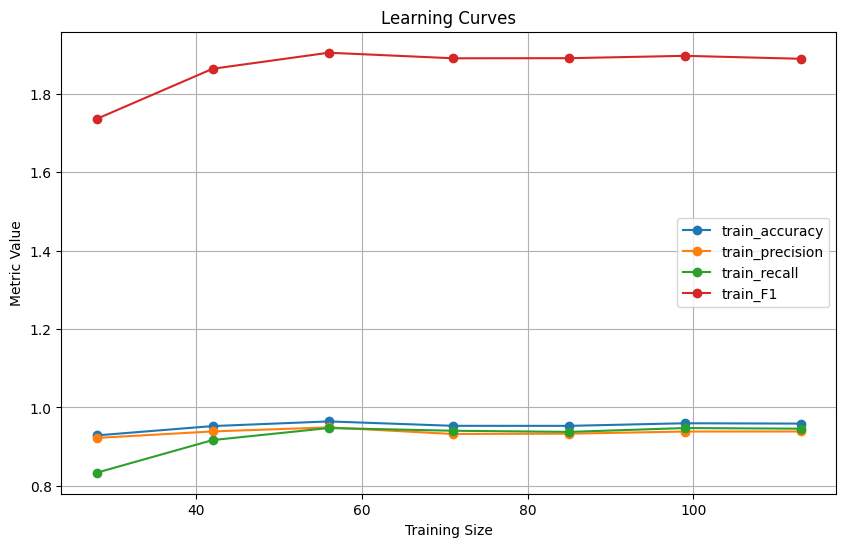

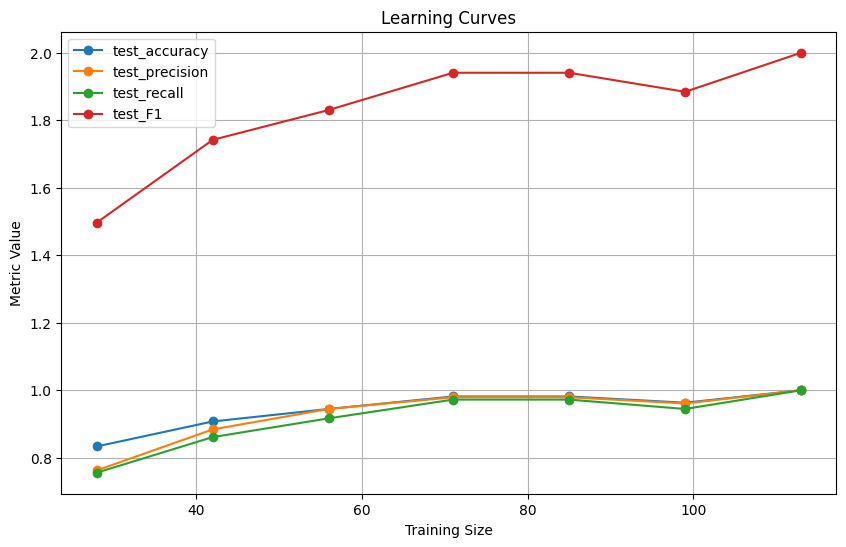

In [15]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=331)
train_sizes = np.linspace(0.2, 0.8, 7)

metrics_dic = {
    'training_size': [],
    'train_accuracy': [],
    'train_precision': [],
    'train_recall': [],
    'train_F1': [],
    'test_accuracy': [],
    'test_precision': [],
    'test_recall': [],
    'test_F1': []
}

for size in train_sizes:
    # resize the X_train, y_train
    X_train_temp, _, y_train_temp, _ = sklearn.model_selection.train_test_split(X_train, y_train, train_size=size,
                                                                                random_state=331)

    # Train Gradient Descent model
    model = LogisticRegression(alpha=0.01, max_iter=70)
    logReg = model.fit(X_train_temp, y_train_temp)

    y_train_hat = model.predict(X_train_temp)
    y_test_hat = model.predict(X_test)
    train_accuracy, train_precision, train_recall, train_F1 \
        = metrics_cal(cMat_builder(y_train_hat, y_train_temp['class'].values))
    test_accuracy, test_precision, test_recall, test_F1 \
        = metrics_cal(cMat_builder(y_test_hat, y_test['class'].values))

    # Compute and store metrics
    metrics_dic['training_size'].append(len(X_train_temp))
    metrics_dic['train_accuracy'].append(train_accuracy)
    metrics_dic['train_precision'].append(train_precision)
    metrics_dic['train_recall'].append(train_recall)
    metrics_dic['train_F1'].append(train_F1)
    metrics_dic['test_accuracy'].append(test_accuracy)
    metrics_dic['test_precision'].append(test_precision)
    metrics_dic['test_recall'].append(test_recall)
    metrics_dic['test_F1'].append(test_F1)

metrics_df_ts = pd.DataFrame(metrics_dic)

train_metrics = ['train_accuracy', 'train_precision', 'train_recall', 'train_F1']
test_metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_F1']

plot_metrics_with_diff_training_size(metrics_df_ts, train_metrics)
plot_metrics_with_diff_training_size(metrics_df_ts, test_metrics)

In [16]:
metrics_df_ts

,training_size,train_accuracy,train_precision,train_recall,train_F1,test_accuracy,test_precision,test_recall,test_F1
0,28,0.928571,0.922078,0.833333,1.736346,0.833333,0.762281,0.755556,1.496325
1,42,0.952381,0.938725,0.916667,1.864343,0.907407,0.883838,0.861111,1.741753
2,56,0.964286,0.949039,0.947368,1.905287,0.944444,0.944444,0.916667,1.830278
3,71,0.953052,0.932174,0.940476,1.891086,0.981481,0.979167,0.972222,1.940605
4,85,0.952941,0.932950,0.937500,1.891342,0.981481,0.979167,0.972222,1.940605
5,99,0.959596,0.938471,0.947368,1.897339,0.962963,0.960784,0.944444,1.884218
6,113,0.958702,0.938573,0.945736,1.889800,1.000000,1.000000,1.000000,2.000000


More training data == Better performance.
And the size of training data has a bigger impact for the performance of trainging set. One possible explanation is the relatively smaller size of training data tend to underrepresente some classes so the performance metrics will have higher variance. On the other hand, we will not find out similiar variations in the test set.

#### 3.3.2 Mini-batch stochastic gradient descent

100%|██████████| 70/70 [00:00<00:00, 105.03it/s]


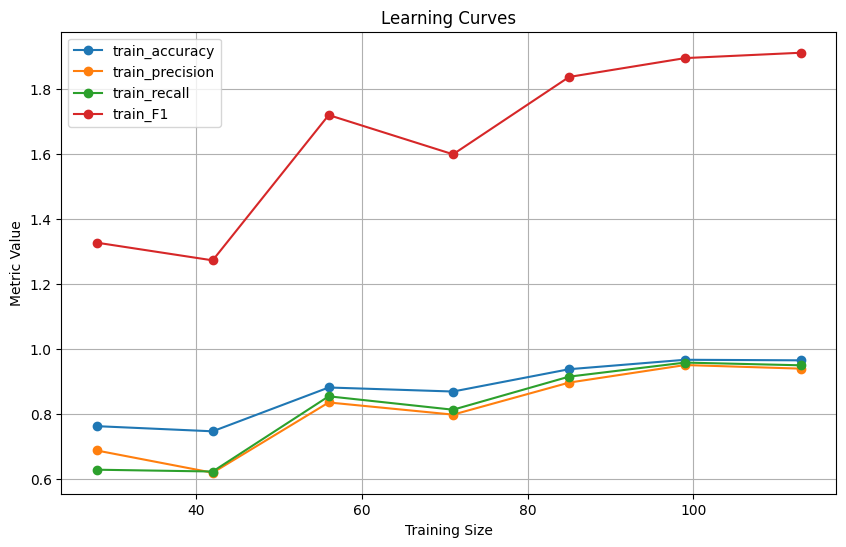

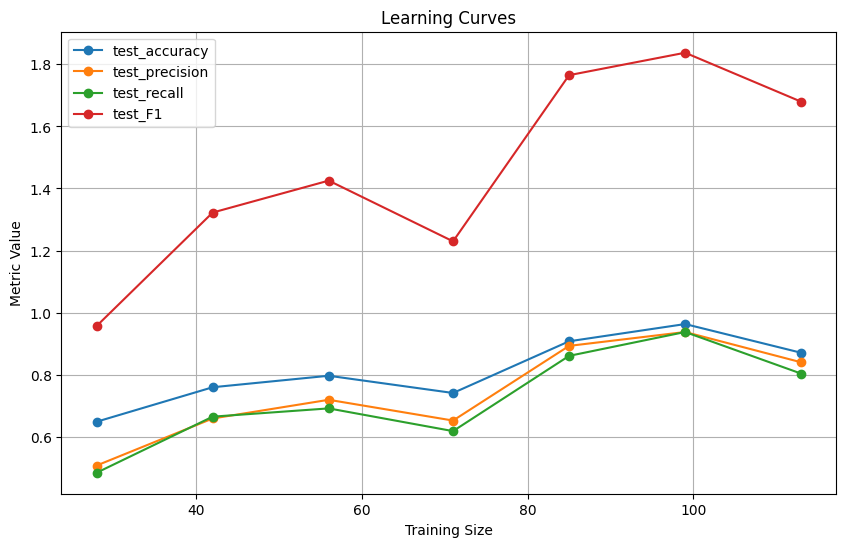

In [17]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=332)
train_sizes = np.linspace(0.2, 0.8, 7)

metrics_dic = {
    'training_size': [],
    'train_accuracy': [],
    'train_precision': [],
    'train_recall': [],
    'train_F1': [],
    'test_accuracy': [],
    'test_precision': [],
    'test_recall': [],
    'test_F1': []
}

for size in train_sizes:
    # resize the X_train, y_train
    X_train_temp, _, y_train_temp, _ = sklearn.model_selection.train_test_split(X_train, y_train, train_size=size, random_state=332)


    # Train SGD Gradient Descent model
    ytrain, ytest = y_train_temp, y_test
    ytrain, ytest = onehot(ytrain), onehot(ytest)
    model_SGD = logReg_SGD(alpha = 0.001, size = [X_train_temp.shape[1], ytrain.shape[1]])
    model_SGD.SGD(X_train_temp, ytrain, epochs = 70, mini_batch_size = 1)

    y_train_hat = model_SGD.predict(X_train_temp)
    y_test_hat = model_SGD.predict(X_test)
    train_accuracy, train_precision, train_recall, train_F1 \
        = metrics_cal(cMat_builder(y_train_hat, y_train_temp['class'].values))
    test_accuracy, test_precision, test_recall, test_F1 \
        = metrics_cal(cMat_builder(y_test_hat, y_test['class'].values))

    # Compute and store metrics
    metrics_dic['training_size'].append(len(X_train_temp))
    metrics_dic['train_accuracy'].append(train_accuracy)
    metrics_dic['train_precision'].append(train_precision)
    metrics_dic['train_recall'].append(train_recall)
    metrics_dic['train_F1'].append(train_F1)
    metrics_dic['test_accuracy'].append(test_accuracy)
    metrics_dic['test_precision'].append(test_precision)
    metrics_dic['test_recall'].append(test_recall)
    metrics_dic['test_F1'].append(test_F1)

metrics_df_ts_m = pd.DataFrame(metrics_dic)

train_metrics = ['train_accuracy', 'train_precision', 'train_recall', 'train_F1']
test_metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_F1']

plot_metrics_with_diff_training_size(metrics_df_ts_m, train_metrics)
plot_metrics_with_diff_training_size(metrics_df_ts_m, test_metrics)

In [18]:
metrics_df_ts_m

,training_size,train_accuracy,train_precision,train_recall,train_F1,test_accuracy,test_precision,test_recall,test_F1
0,28,0.761905,0.687037,0.627778,1.327046,0.648148,0.506944,0.483720,0.956745
1,42,0.746032,0.618493,0.622222,1.272481,0.759259,0.658547,0.664428,1.322372
2,56,0.880952,0.834890,0.853801,1.719967,0.796296,0.718806,0.691087,1.425335
3,71,0.868545,0.797407,0.812516,1.599078,0.740741,0.651852,0.617827,1.229537
4,85,0.937255,0.896024,0.914423,1.837272,0.907407,0.892593,0.860399,1.765259
5,99,0.966330,0.950117,0.957676,1.895383,0.962963,0.937322,0.937322,1.837607
6,113,0.964602,0.938990,0.949277,1.911909,0.870370,0.839683,0.803215,1.679706


The similiar trend in there. However, SGD is more senstive to the size of training data because the noise can dominate in the small size of trainging data, which can lead to the very erratic weight updates.

### 3.4 Growing minibatch sizes for SGD

In [19]:
# Convergence speed and final performance of different batch sizes vs batch gd
batch_sizes = [1,4,8,16,32,64,128]

for batch in batch_sizes:
    # Initialize data
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5, random_state=340)
    ytrain, ytest = y_train, y_test
    ytrain, ytest = onehot(ytrain), onehot(ytest)

    # SGD fitting
    model_SGD = logReg_SGD(alpha = 0.01, eps=0.001, size = [X_train.shape[1], ytrain.shape[1]])
    model_SGD.SGD(X_train, ytrain, epochs = 500, mini_batch_size = batch)
    ypred = model_SGD.predict(X_test)
    printMetrics(cMat_builder(ypred, y_test['class'].values))

100%|██████████| 500/500 [00:03<00:00, 128.77it/s]


Metrics for avg_accuracy: 0.992509, avg_precision: 0.986111, avg_recall: 0.991453, avg_F1: 1.984474


  8%|▊         | 41/500 [00:00<00:01, 322.20it/s]


Metrics for avg_accuracy: 0.955056, avg_precision: 0.929636, avg_recall: 0.938974, avg_F1: 1.883383


100%|██████████| 500/500 [00:00<00:00, 1656.06it/s]


Metrics for avg_accuracy: 0.977528, avg_precision: 0.961538, avg_recall: 0.974359, avg_F1: 1.954834


  1%|          | 6/500 [00:00<00:00, 1059.35it/s]


Metrics for avg_accuracy: 0.565543, avg_precision: 0.355583, avg_recall: 0.358603, avg_F1: 0.707574


  9%|▊         | 43/500 [00:00<00:00, 2124.05it/s]


Metrics for avg_accuracy: 0.685393, avg_precision: 0.524492, avg_recall: 0.541434, avg_F1: 1.111606


 25%|██▌       | 126/500 [00:00<00:00, 2386.01it/s]


Metrics for avg_accuracy: 0.715356, avg_precision: 0.579947, avg_recall: 0.592304, avg_F1: 1.079273


  9%|▉         | 45/500 [00:00<00:00, 2783.42it/s]


Metrics for avg_accuracy: 0.617978, avg_precision: 0.434343, avg_recall: 0.434122, avg_F1: 0.820305


https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu

Morderate batch size (8, in the experiment) has the best performance. It reaches the same accuracy as using batch size 1 or 4 which means it converge 8 or 4 times faster than the comparisons. For the large batch size, it converges so fast but also overfits the training data due to their poor performance for the test data.

### 3.5 Different learning rates (3+)

#### 3.5.1 Gradient descent

100%|██████████| 50/50 [00:00<00:00, 1284.19it/s]


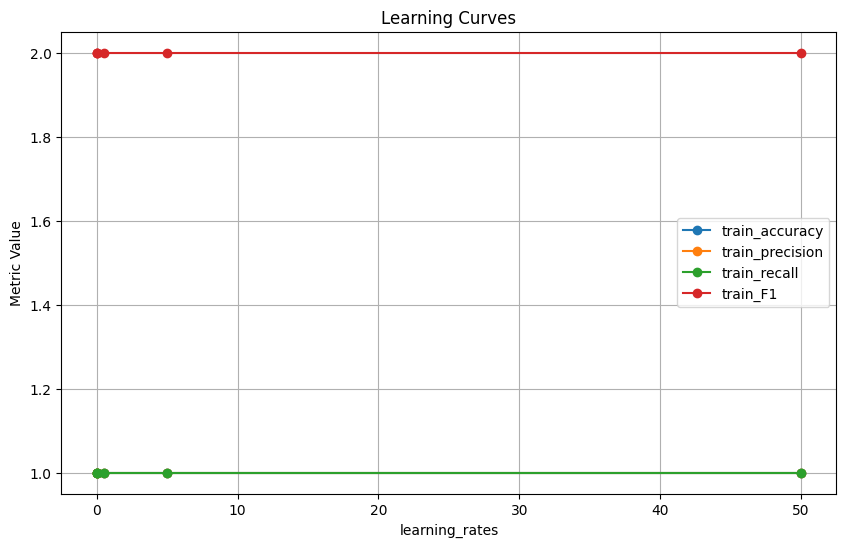

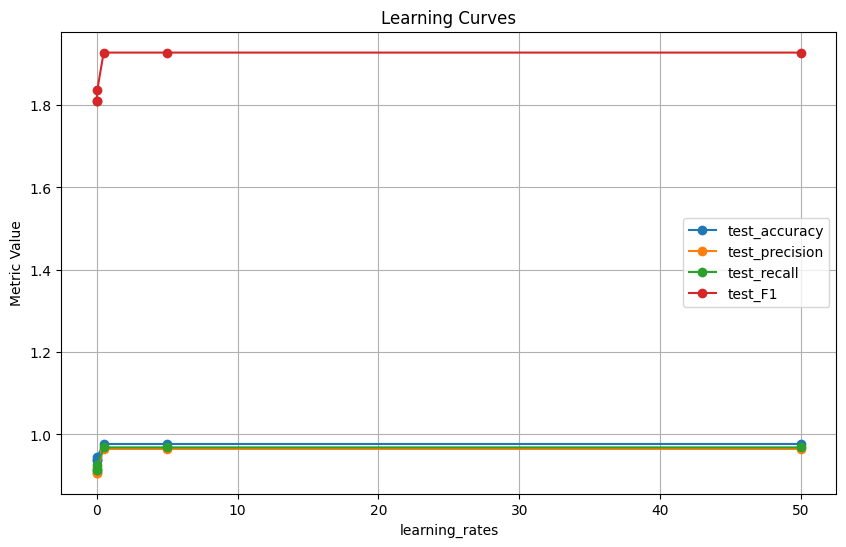

In [20]:
learning_rates = [0.0005, 0.005, 0.05, 0.5, 5, 50]
metrics_dic_lr = {
    'learning_rates': [],
    'train_accuracy': [],
    'train_precision': [],
    'train_recall': [],
    'train_F1': [],
    'test_accuracy': [],
    'test_precision': [],
    'test_recall': [],
    'test_F1': []
}
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.95, random_state=351)
for lr in learning_rates:
    model = LogisticRegression(alpha=lr, max_iter=50)
    logReg = model.fit(X_train, y_train)

    y_train_hat = model.predict(X_train)
    y_test_hat = model.predict(X_test)
    train_accuracy, train_precision, train_recall, train_F1 \
        = metrics_cal(cMat_builder(y_train_hat, y_train['class'].values))
    test_accuracy, test_precision, test_recall, test_F1 \
        = metrics_cal(cMat_builder(y_test_hat, y_test['class'].values))

    # Compute and store metrics
    metrics_dic_lr['learning_rates'].append(lr)
    metrics_dic_lr['train_accuracy'].append(train_accuracy)
    metrics_dic_lr['train_precision'].append(train_precision)
    metrics_dic_lr['train_recall'].append(train_recall)
    metrics_dic_lr['train_F1'].append(train_F1)
    metrics_dic_lr['test_accuracy'].append(test_accuracy)
    metrics_dic_lr['test_precision'].append(test_precision)
    metrics_dic_lr['test_recall'].append(test_recall)
    metrics_dic_lr['test_F1'].append(test_F1)

metrics_df_lr = pd.DataFrame(metrics_dic_lr)
plot_metrics_with_diff_learning_rates(metrics_df_lr, ['train_accuracy', 'train_precision', 'train_recall', 'train_F1'])
plot_metrics_with_diff_learning_rates(metrics_df_lr, ['test_accuracy', 'test_precision', 'test_recall', 'test_F1'])

In [21]:
metrics_df_lr

,learning_rates,train_accuracy,train_precision,train_recall,train_F1,test_accuracy,test_precision,test_recall,test_F1
0,0.0005,1.0,1.0,1.0,2.0,0.937255,0.906938,0.913610,1.808695
1,0.0050,1.0,1.0,1.0,2.0,0.937255,0.906938,0.913610,1.808695
2,0.0500,1.0,1.0,1.0,2.0,0.945098,0.917201,0.925306,1.837185
3,0.5000,1.0,1.0,1.0,2.0,0.976471,0.964282,0.968102,1.927450
4,5.0000,1.0,1.0,1.0,2.0,0.976471,0.964282,0.968102,1.927450
5,50.0000,1.0,1.0,1.0,2.0,0.976471,0.964282,0.968102,1.927450


For gradient descent model, larger learning rate leads to the faster converge speed.

#### 3.5.2 Mini-batch stochastic gradient Descent

100%|██████████| 100/100 [00:00<00:00, 2614.90it/s]


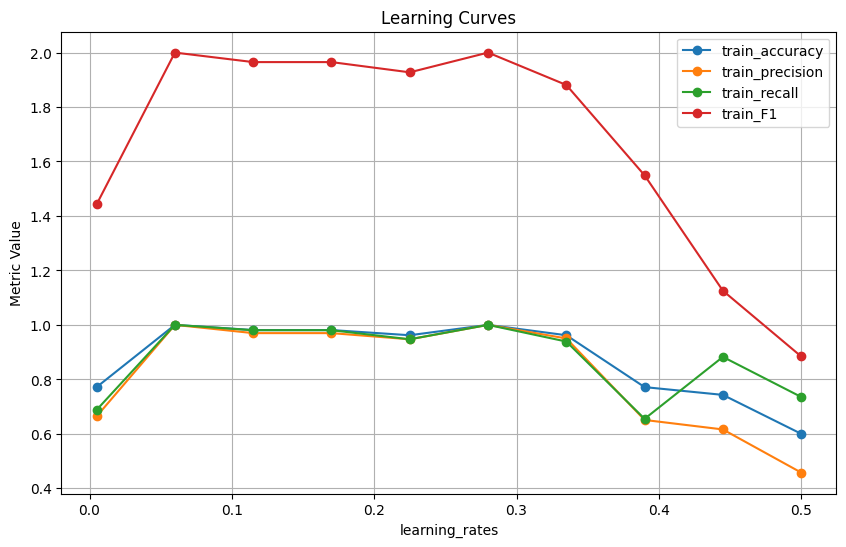

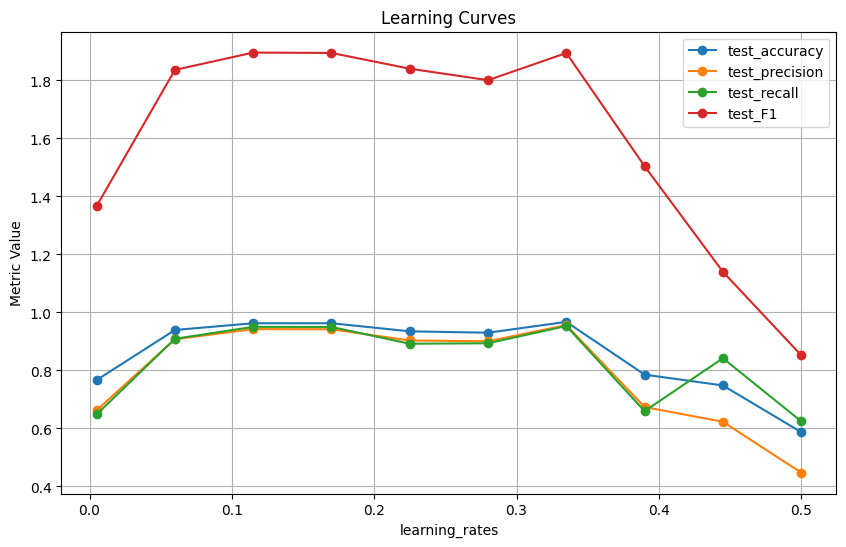

In [22]:
learning_rates = np.linspace(0.005, 0.50, 10)
metrics_dic_lr = {
    'learning_rates': [],
    'train_accuracy': [],
    'train_precision': [],
    'train_recall': [],
    'train_F1': [],
    'test_accuracy': [],
    'test_precision': [],
    'test_recall': [],
    'test_F1': []
}
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.8, random_state=361)
for lr in learning_rates:
    # Train SGD Gradient Descent model
    ytrain, ytest = y_train, y_test
    ytrain, ytest = onehot(ytrain), onehot(ytest)
    model_SGD = logReg_SGD(alpha = lr, size = [X_train.shape[1], ytrain.shape[1]])
    model_SGD.SGD(X_train, ytrain, epochs = 100, mini_batch_size = 8)

    y_train_hat = model_SGD.predict(X_train)
    y_test_hat = model_SGD.predict(X_test)
    train_accuracy, train_precision, train_recall, train_F1 \
        = metrics_cal(cMat_builder(y_train_hat, y_train['class'].values))
    test_accuracy, test_precision, test_recall, test_F1 \
        = metrics_cal(cMat_builder(y_test_hat, y_test['class'].values))

    # Compute and store metrics
    metrics_dic_lr['learning_rates'].append(lr)
    metrics_dic_lr['train_accuracy'].append(train_accuracy)
    metrics_dic_lr['train_precision'].append(train_precision)
    metrics_dic_lr['train_recall'].append(train_recall)
    metrics_dic_lr['train_F1'].append(train_F1)
    metrics_dic_lr['test_accuracy'].append(test_accuracy)
    metrics_dic_lr['test_precision'].append(test_precision)
    metrics_dic_lr['test_recall'].append(test_recall)
    metrics_dic_lr['test_F1'].append(test_F1)

metrics_df_lr_m = pd.DataFrame(metrics_dic_lr)
plot_metrics_with_diff_learning_rates(metrics_df_lr_m, ['train_accuracy', 'train_precision', 'train_recall', 'train_F1'])
plot_metrics_with_diff_learning_rates(metrics_df_lr_m, ['test_accuracy', 'test_precision', 'test_recall', 'test_F1'])

In [23]:
metrics_df_lr_m

,learning_rates,train_accuracy,train_precision,train_recall,train_F1,test_accuracy,test_precision,test_recall,test_F1
0,0.005,0.771429,0.664021,0.687745,1.442688,0.766900,0.662632,0.648435,1.366614
1,0.060,1.000000,1.000000,1.000000,2.000000,0.939394,0.907541,0.908994,1.835748
2,0.115,0.980952,0.969697,0.980392,1.965065,0.962704,0.942442,0.950254,1.895504
3,0.170,0.980952,0.969697,0.980392,1.965065,0.962704,0.941849,0.949891,1.894300
4,0.225,0.961905,0.947059,0.947059,1.927451,0.934732,0.903270,0.892061,1.839934
5,0.280,1.000000,1.000000,1.000000,2.000000,0.930070,0.900564,0.893686,1.800397
6,0.335,0.961905,0.950089,0.938725,1.881017,0.967366,0.956150,0.953102,1.894014
7,0.390,0.771429,0.650794,0.654902,1.549089,0.785548,0.673830,0.659653,1.503940
8,0.445,0.742857,0.615942,0.882353,1.125462,0.748252,0.623134,0.842048,1.139966
9,0.500,0.600000,0.457516,0.735294,0.884061,0.587413,0.447958,0.624728,0.852486


Best range of learning rate for SGD is [0.01, 0.08] when we doing the leave-one-out SGD with 100 epochs. When learning rate below 0.01, we need more epochs to make it converge for best performance. On the other hand, much higher learning rate (larger than 0.08) has far worse performance comparing to a moderate learning rate because it may overshoot the minimum during the stochastic process.

### 3.6 Optimal Parameter Selection (SGD)

In [24]:
# Use epoch=1 to make the task more challenging for SGD
batch_sizes = [1, 4, 8, 16, 32]
learning_rates = [0.00625, 0.0125, 0.025, 0.05, 0.075, 0.1, 0.15]
# learning_rates = np.linspace(0.005, 0.30, 20)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=360)
configs_dic = {
    'batch_sizes': [],
    'learning_rates': [],
    'cv_F1': []
}
for batch_size in batch_sizes:
    for lr in learning_rates:
        # Use 5 folds CV to calculate the F1
        folds_indices = split_indices(wine_df.index.tolist())
        for idx, indices in enumerate(split_indices(wine_df.index.tolist())):
            X_train = X.iloc[np.concatenate(folds_indices[:idx] + folds_indices[idx + 1:])]
            X_test = X.iloc[indices.tolist()]
            y_train = y.iloc[np.concatenate(folds_indices[:idx] + folds_indices[idx + 1:])]
            y_test = y.iloc[indices.tolist()]

            ytrain, ytest = onehot(y_train), onehot(y_test)
            model_SGD = logReg_SGD(alpha=lr, size=[X_train.shape[1], ytrain.shape[1]])
            model_SGD.SGD(X_train, ytrain, epochs=1, mini_batch_size=batch_size)

            # draw_loss(logReg.L_vals)
            y_train_hat = model_SGD.predict(X_train)
            y_test_hat = model_SGD.predict(X_test)
            _, _, _, test_F1 = metrics_cal(
                cMat_builder(y_test_hat, y_test['class'].values))

            configs_dic['batch_sizes'].append(batch_size)
            configs_dic['learning_rates'].append(lr)
            configs_dic['cv_F1'].append(test_F1)

configs_dic_df = pd.DataFrame(configs_dic)

100%|██████████| 1/1 [00:00<00:00, 437.64it/s]


In [25]:
configs_dic_df

,batch_sizes,learning_rates,cv_F1
0,1,0.00625,1.147284
1,1,0.00625,1.077784
2,1,0.00625,1.254439
3,1,0.00625,1.502503
4,1,0.00625,1.036602
...,...,...,...
170,32,0.15000,0.776519
171,32,0.15000,1.136182
172,32,0.15000,1.011908
173,32,0.15000,1.156817


In [26]:
configs_dic_df[configs_dic_df['cv_F1'] == np.max(configs_dic_df['cv_F1'])]

,batch_sizes,learning_rates,cv_F1
17,1,0.050,2.0
23,1,0.075,2.0


100%|██████████| 1/1 [00:00<00:00, 129.85it/s]


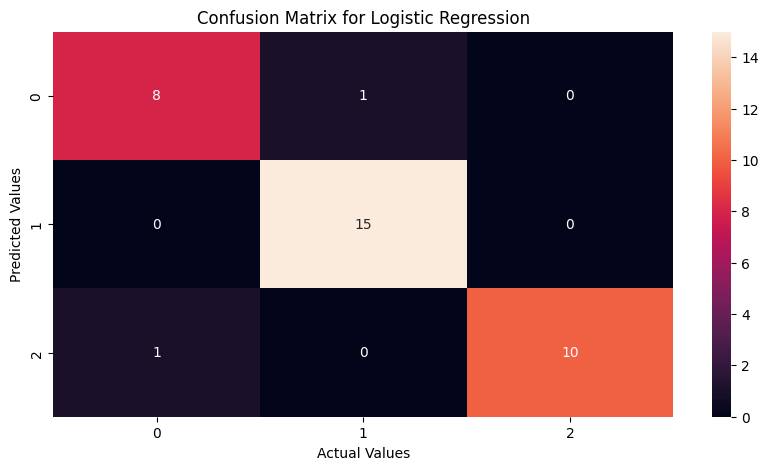

100%|██████████| 1/1 [00:00<00:00, 165.03it/s]


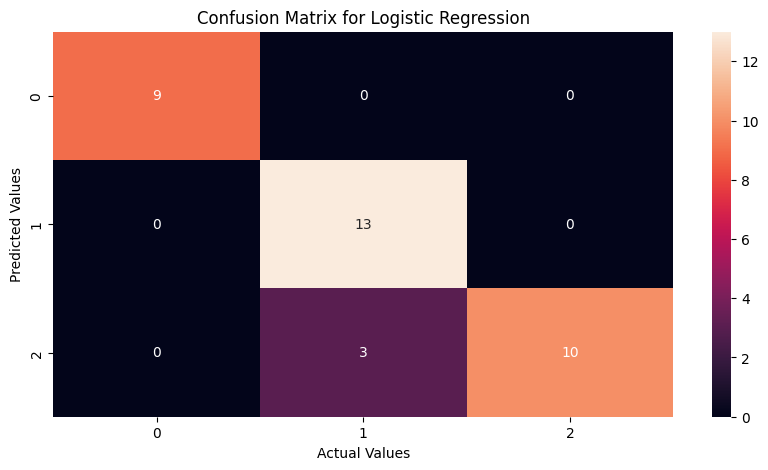

100%|██████████| 1/1 [00:00<00:00, 161.34it/s]


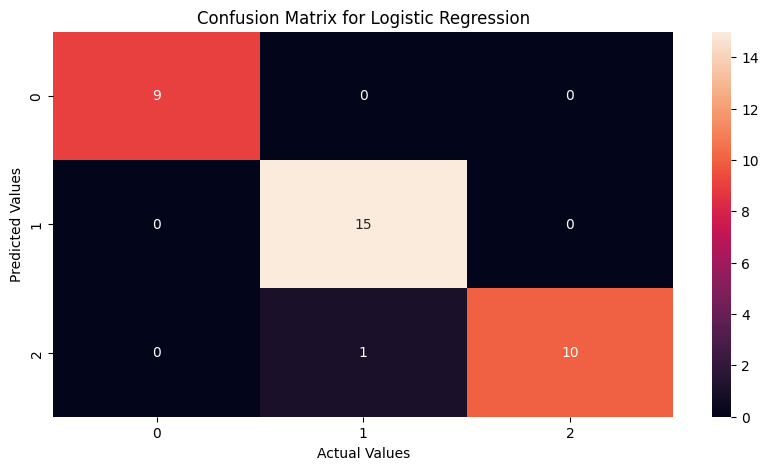

100%|██████████| 1/1 [00:00<00:00, 88.01it/s]


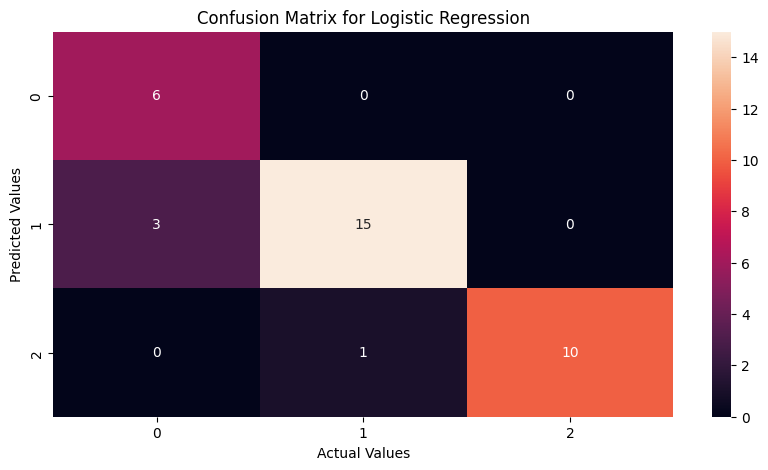

100%|██████████| 1/1 [00:00<00:00, 160.86it/s]


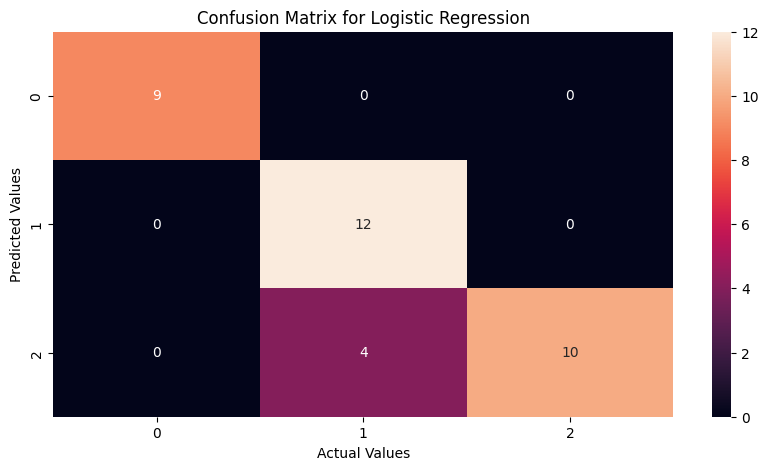

100%|██████████| 1/1 [00:00<00:00, 85.57it/s]


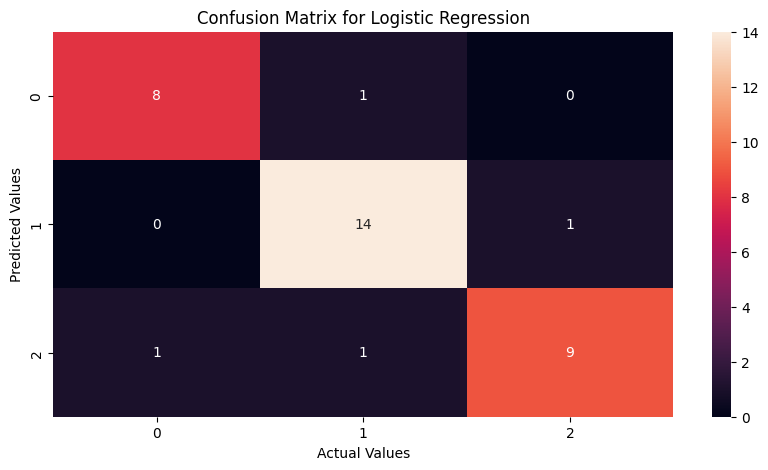

100%|██████████| 1/1 [00:00<00:00, 143.53it/s]


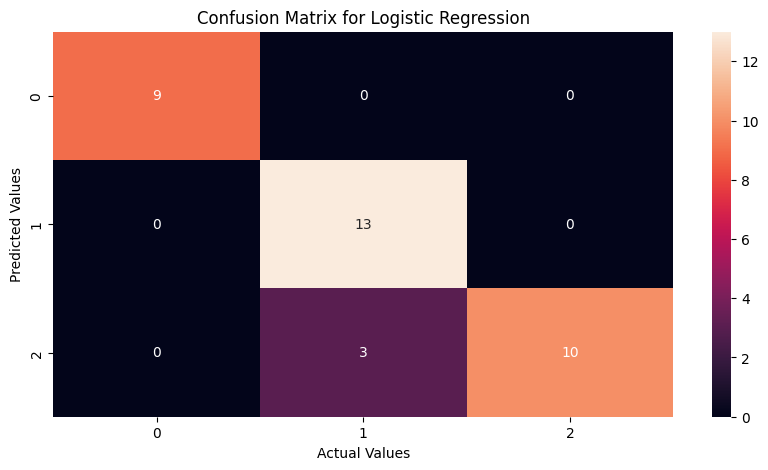

100%|██████████| 1/1 [00:00<00:00, 122.82it/s]


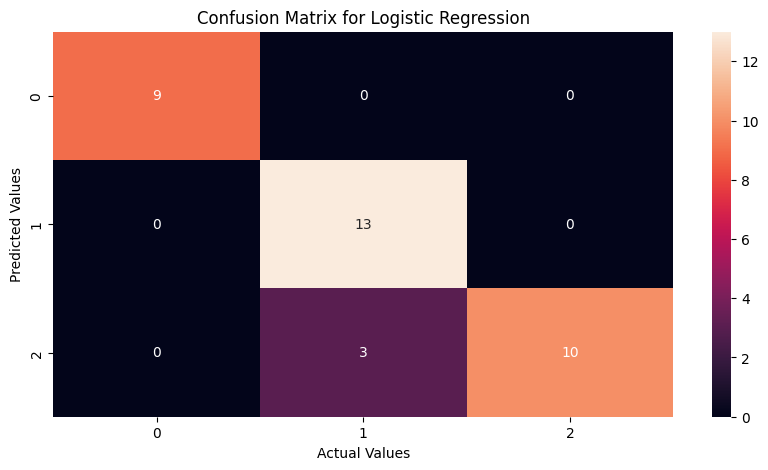

100%|██████████| 1/1 [00:00<00:00, 141.29it/s]


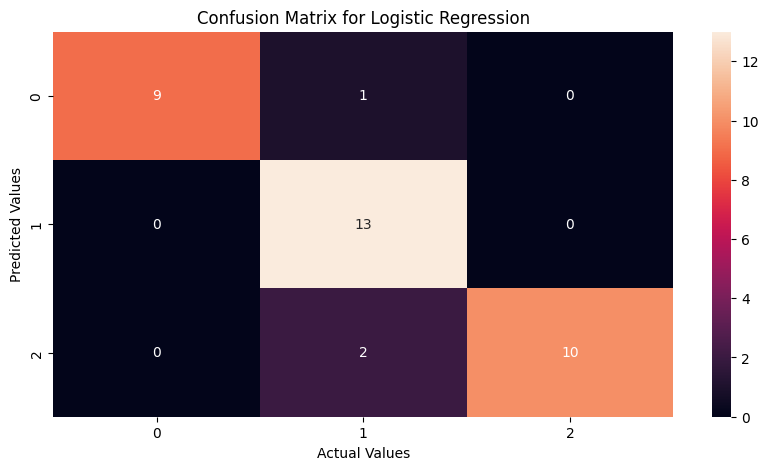

100%|██████████| 1/1 [00:00<00:00, 137.82it/s]


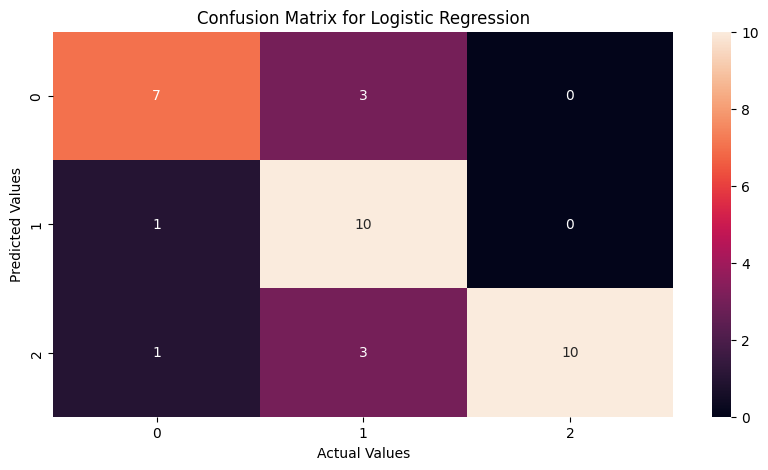

Metrics for avg_accuracy: 0.933333, avg_precision: 0.905620, avg_recall: 0.914491, avg_F1: 1.827151


In [27]:
# Best combination: batch_sizes=1, lr=0.05
# Testing out SGD logistic regression
mean = np.array(np.zeros(4).reshape(4,))
num_iter = 10
for i in range(num_iter):
  ytrain, ytest = y_train, y_test
  ytrain, ytest = onehot(ytrain), onehot(ytest)
  model_SGD = logReg_SGD(alpha=0.05, size=[X_train.shape[1], ytrain.shape[1]])
  model_SGD.SGD(X_train, ytrain, epochs=1, mini_batch_size=1, test_data=(X_test, ytest))
  ypred = onehot(np.array(model_SGD.predict(X_test)))
  mean += np.array(metrics_cal(cMatrix_log(ypred, ytest, axis=(1, 1), onehot=True)))

mean = mean/num_iter
print("Metrics for avg_accuracy: %f, avg_precision: %f, avg_recall: %f, avg_F1: %f" % (
        mean[0],mean[1],mean[2],mean[3]))

Performance metrics choosing: we choose F1 becuase the distribution of three classes of wine are inbalance. In the wine dataset, class 2 (most popular one) has 47.9% more data than class 3 (least popular one) so a model with high accuracy does not necessarily mean it performs well on the least popular class. On the other hand, we don't have preference for the lower Type I error or the Type II error so we should choose F1 over the precision and recall.

### 3.9 Creative Experiments

#### 3.9.1 Feature Extraction using L1 Regularization

In [28]:
def grad_L_m_L1(X, y, beta, lambda_val=0):
    # Gradient with L1 regularization term
    original_gradient = (np.transpose(Xhat(X)) @ (softmax(Xhat(X) @ beta) - y)) / X.shape[0]
    # No penalization for intercept
    original_gradient[1:] += lambda_val * np.sign(beta[1:])
    return original_gradient


def eval_L_m_L1(X, y, beta, lambda_val=0):
    # Including L1 regularization term
    l1_penalty = lambda_val * np.sum(np.abs(beta))
    return np.average([cross_entropy(y[index], softmax(xi @ beta)) for index, xi in enumerate(Xhat(X))]) + l1_penalty


def train_model_using_grad_descent_multi_L1(X, y, alpha, max_iter, eps, lambda_val=0):
    beta = np.zeros((X.shape[1] + 1, y.shape[1])).astype("float64")
    L_vals = []
    for _ in tqdm(range(max_iter)):
        grad_matrix = grad_L_m_L1(X, y, beta, lambda_val)
        if np.linalg.norm(grad_matrix) < eps:
            break
        beta = beta - alpha * grad_matrix
        L_vals.append(eval_L_m_L1(X, y, beta, lambda_val))
    return beta, L_vals

class LogisticRegression_L1:
    def __init__(self, alpha=0.01, max_iter=500, eps=1e-2, lambda_val=0.1):
        self.beta = None
        self.L_vals = None
        self.alpha = alpha
        self.max_iter = max_iter
        self.eps = eps
        self.lambda_val = lambda_val  # L1 regularization strength

    def fit(self, X_train, y_train):
        # one-hot-encoding y_train
        unique_classes, inverse = np.unique(y_train, return_inverse=True)
        y_train_hot = np.zeros((len(y_train), len(unique_classes)))
        y_train_hot[np.arange(len(y_train)), inverse] = 1

        self.beta, self.L_vals = train_model_using_grad_descent_multi_L1(X_train, y_train_hot, self.alpha,
                                                                         self.max_iter,
                                                                         self.eps, self.lambda_val)
        return self

    def predict(self, X_test):
        # first class in y_pred is class 2 in Y
        y_pred = [np.argmax(yi) + 1 for yi in (Xhat(X_test) @ self.beta)]
        return y_pred

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=390)
model_L1 = LogisticRegression_L1(alpha=0.01, max_iter=1500, lambda_val=0.5)
logReg_L1 = model_L1.fit(X_train, y_train)

avg_coef = np.mean(np.abs(logReg_L1.beta[1:]), axis=1)
coef_filtered = np.array([coef if coef > 1e-3 else 0 for coef in avg_coef])
coef_filtered

100%|██████████| 1500/1500 [00:12<00:00, 124.87it/s]


array([0.00187294, 0.00257853, 0.        , 0.00341086, 0.0029765 ,
       0.00288077, 0.00259298, 0.00317285, 0.00359585, 0.00396642,
       0.00618964, 0.00189599, 0.00205393])

The best test set f1 for the gradient descent model is 1.96 and for the stochastic gradient descent model with optimal parameter is 1.93. Aiming to get the higher f1, we decide to go back to look at the results from Exploratory Data Analysis. From the correlation heatmap, we find the correlation between feature "Ash" and label" class is the lowest one (-0.05). Then we dicede to use Lasso Regularization technique to do feature extraction, which is a more rigurous way to excule the potential insignificant features.

We use a fairly large lambda (0.5) to get a higher penalization speed. After 1500 iterations, the average coefficient of "Ash" got penalized below the threshold (1e-3). Then we refit the both models without using "Ash" feature.

100%|██████████| 20/20 [00:00<00:00, 128.59it/s]


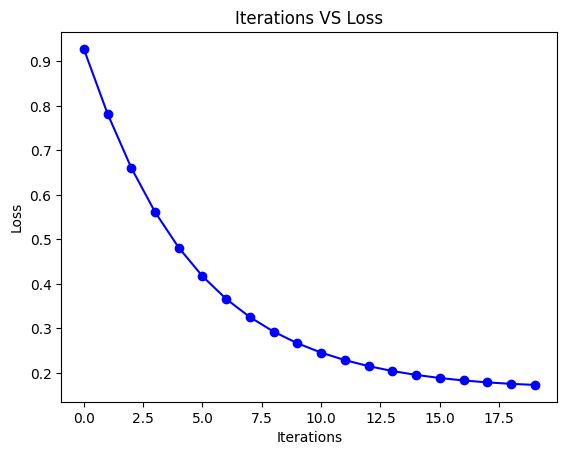

Overall Accuracy for training set:  0.9436619718309859
Performance metrics for training set: 


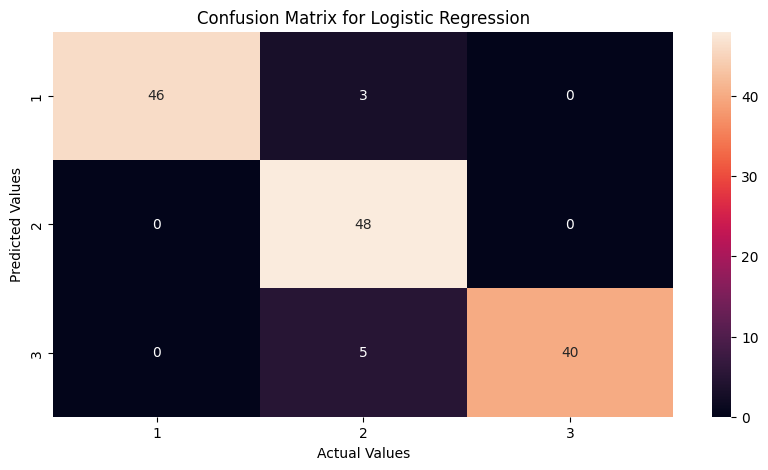

Metrics for avg_accuracy: 0.962441, avg_precision: 0.942555, avg_recall: 0.952381, avg_F1: 1.902610
Overall Accuracy for test set:  0.8888888888888888
Performance metrics for test set:


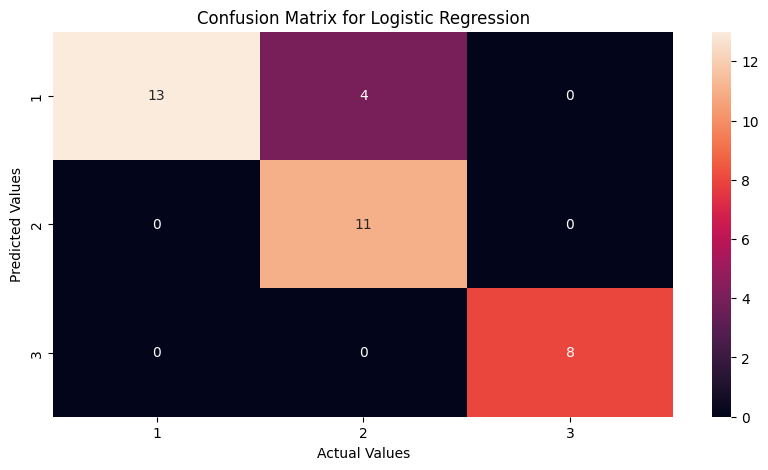

Metrics for avg_accuracy: 0.925926, avg_precision: 0.921569, avg_recall: 0.911111, avg_F1: 1.788159


In [29]:
# Third feature got penalized to zero. Let's exclude it from model
X_train_new = X_train.drop(columns=['Ash'])
X_test_new = X_test.drop(columns=['Ash'])

# Test using gradient descent
model_GD_L1 = LogisticRegression(alpha=0.1, max_iter=20)
logReg = model_GD_L1.fit(X_train_new, y_train)

draw_loss(logReg.L_vals)
y_train_hat = model_GD_L1.predict(X_train_new)
y_test_hat = model_GD_L1.predict(X_test_new)
metricsWrapper(y_train_hat, y_train['class'].values, y_test_hat, y_test['class'].values)

100%|██████████| 30/30 [00:00<00:00, 137.00it/s]


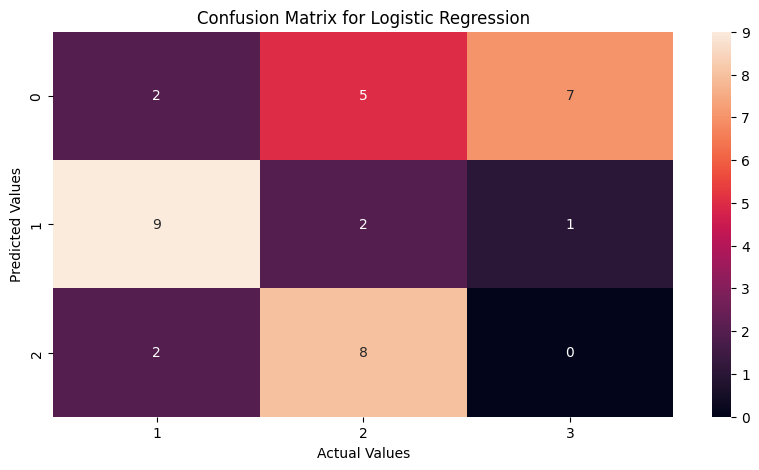

Metrics for avg_accuracy: 0.407407, avg_precision: 0.103175, avg_recall: 0.095726, avg_F1: 0.248005


In [30]:
# Test using SGD
model_SGD = logReg_SGD(alpha=0.1, size=[X_train_new.shape[1], y_train.shape[1]])
model_SGD.SGD(X_train_new, ytrain, epochs=30, mini_batch_size=1, test_data=(X_test_new, y_test))
ypred = model_SGD.predict(X_test_new)
printMetrics(cMatrix_log(ypred, y_test['class'].values, axis=(1, 1), onehot=False))

Aftger excluding the "Ash" featuer, the f1 score drops 9% on average for both models. However, the performance drop is tolerable because the new models require 8% less data than before. If there are some difficulties to collect the "Ash" data, excluding it can be an appropriate solution.